##### Отправляем сообщения всегда, но узел может быть не активен (блокирован) тогда сообщение ставится в очередь на узел
##### после блокировки узел считается снова свободным если очередь < L*0,5
##### число узлов 300, поток ренерируется 150 шагов, плотность сети 3,54
MultiplierThresholdToBlock <strong>L 50</strong>, FractionThresholdToUnBlock 0,5, UseOnlyIsActiveNodes True, NumberOfGenerations 150 <br>


In [1]:
#!pip install matplotlib-label-lines
import pandas
print(pandas.__version__)
#!pip install --upgrade pandas

1.3.5


In [2]:
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime
import pandas as pd
import os
from labellines import labelLine, labelLines
  
log_dir_path = os.path.abspath('..\\..\\')+"\\Result"
numberOfGenerations = 150;
percolation = 0.34;
nodeCount=300;

files = [
    {"filename": "Netsim-Node-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на узле на обработку", "ylabel":"Число сообщений" },
    {"filename": "Netsim-Node-Metrics-load-{log_tag}", "title": "Загрузка узлов", "ylabel":"Доля от производительности узла" },
    #{"filename": "Netsim-Connection-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на связи"},
    {"filename": "Netsim-Connection-Metrics-load-{log_tag}", "title": "Средняя загрузка связей", "ylabel":"Доля от производительности связи" },
    {"filename": "Netsim-Message-Metrics-failed-{log_tag}", "title": "Число потерянных сообщений", "ylabel":"Число сообщений" },
]

filesBlocked = [
    {"filename": "Netsim-Node-Metrics-blocked-{log_tag}", "title": "Доля блокированных узлов" },
]
filesInfected = [
    {"filename": "Netsim-Node-Metrics-IsInfected-{log_tag}", "title": "Доля инфицированных узлов" },
]

filesMessage = [
    {"filename": "Netsim-Message-Metrics-{log_tag}", "title": "Число доставленных сообщений с течением времени" },

]
summBlocked = pd.DataFrame();
summInfected = pd.DataFrame();
MessageResived = pd.DataFrame();
MessageFall = pd.DataFrame();
MessageTimeSpent = pd.DataFrame();
          
def load_csv_file(path):
    file = open(path)
    data = file.readlines()
    splitted_data = [x.split(',') for x in data]
    return splitted_data, len(splitted_data[0])


def aggeregate_line(array):
    aggregated = [sum([float(y) for y in x])/len(x) for x in array]
    return aggregated, len(aggregated)


def showStat():
    for file in files:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel(file['ylabel'])
        
        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line(data)
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label'])    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
        #labelLines(plt.gca().get_lines(), zorder=2.5)
        #lines = plt.gca().get_lines();
        #print(len(lines))
        #xvals = get_xvals(lines)
        #for idx in range(len(lines)-1):
        #    labelLine(lines[idx+1], get_x(xvals, idx, len(lines)-1), label=str(idx+1), fontsize=14, align=False)
                                   
    plt.show()
                                           
def get_xvals(lines):
    ax = lines[0].axes
    shrink_factor = 0.05
    xvals = ax.get_xlim()
    xvals_rng = xvals[1] - xvals[0]
    shrinkage = xvals_rng * shrink_factor
    xvals = (xvals[0] + shrinkage, xvals[1] - shrinkage)
    return xvals;
                                           
def get_x(xvals, i, count):
    h = (xvals[1] - xvals[0])/(count+1);
    return h*(i+1)+xvals[0];
                                           
                                           
def aggeregate_line_perc_node(array):
    aggregated = [sum([1 for y in x if float(y) > 0])/len(x) for x in array]
    return aggregated, len(aggregated)

def showStatInfected():
    for file in filesInfected:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.axhline(y=percolation, color='r', linestyle='-')
        plt.xlabel("Шаги")
        plt.ylabel("Доля инфицированных узлов")

        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line_perc_node(data)
            summ = np.sum(aggregated)
            summInfected.at[quantity, log_tag['label']] = summ/count;
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()

def showStatBlocked():
    for file in filesBlocked:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.axhline(y=percolation, color='r', linestyle='-')
        plt.xlabel("Шаги")
        plt.ylabel("Доля блокированных узлов")

        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            dataI, line_lenI = load_csv_file(f"{log_dir_path}/{filesInfected[0]['filename'].format(log_tag = log_tag['tag'])}")
                                           
            aggregated, count = aggeregate_line_perc_node(data)
            aggregatedI, count = aggeregate_line_perc_node(dataI)
            aggregated = np.array(aggregated) - np.array(aggregatedI)
            summ = np.sum(aggregated)
            summBlocked.at[quantity, log_tag['label']] = summ/count;
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    showStatInfected();

def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")

def load_csv_file_message(path):
    file = open(path)
    data = file.readlines()
    t = datetime(2021,6,1,1)
   
    splitted_data = [(str2bool(x.split(',')[-2]), (datetime.strptime(x.split(',')[-1], '%d.%m.%Y %H:%M:%S\n')-t).total_seconds(), float(x.split(',')[2]))  for x in data]
    df = pd.DataFrame(data=splitted_data,  columns=['Resived', 'Time' ,'TimeSpent']);
    total_count = len(df.index);
    timeSpent_avr = df['TimeSpent'].mean();
    df = df.loc[df['Resived'] == True]
    agg= df.groupby(['Time']).count()
    return agg['Resived'].to_numpy(), agg.index.get_level_values(0).to_numpy(), total_count, timeSpent_avr

def showStatMessage():
    for file in filesMessage:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel("Число сообщений")
       
        for log_tag in log_tags:
            data, line_len, all_count, timeSpent_avr = load_csv_file_message(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            summ = np.sum(data);
            fall = (all_count-summ)*100/all_count;
            print('Доставлено '+str(summ)+' Потеряно '+ "{:3.4f}".format(fall)+'% -'+log_tag['label']);
            
            MessageResived.at[quantity, log_tag['label']] = summ*100/all_count;
            MessageFall.at[quantity, log_tag['label']] = fall;
            MessageTimeSpent.at[quantity, log_tag['label']] = timeSpent_avr;
            ax.plot(line_len, data, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    plt.show()


<strong>Поток Quantity 100 </strong>

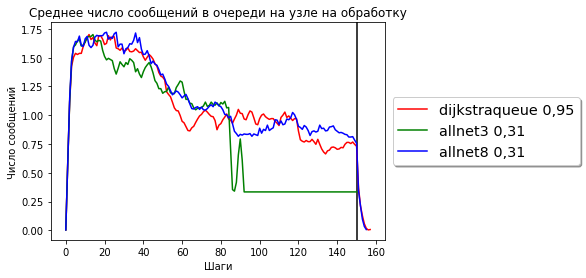

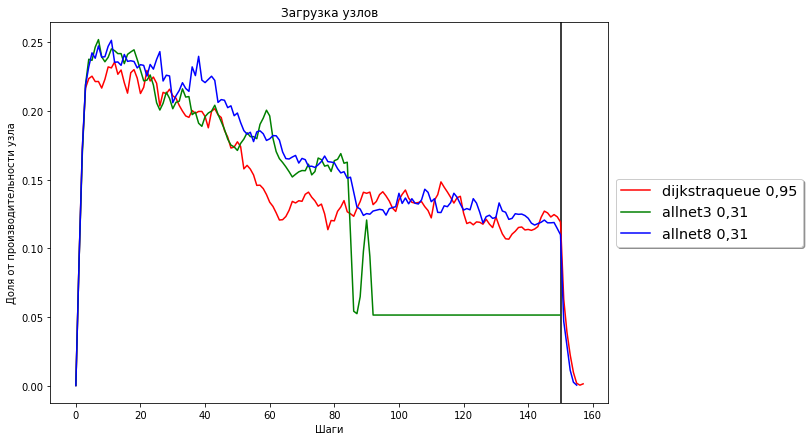

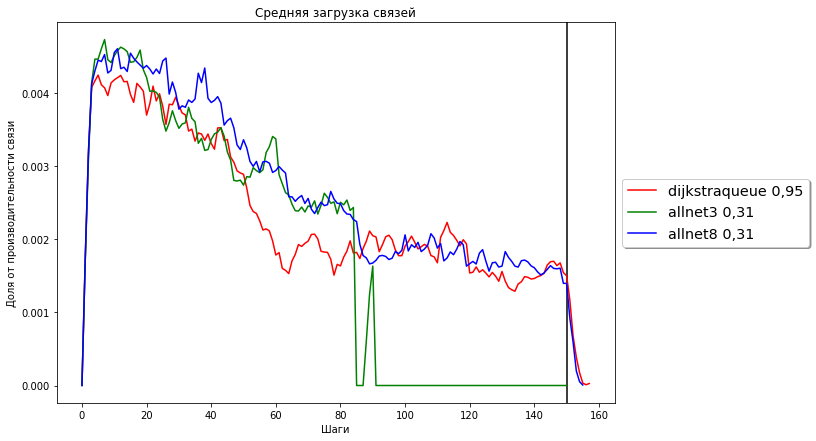

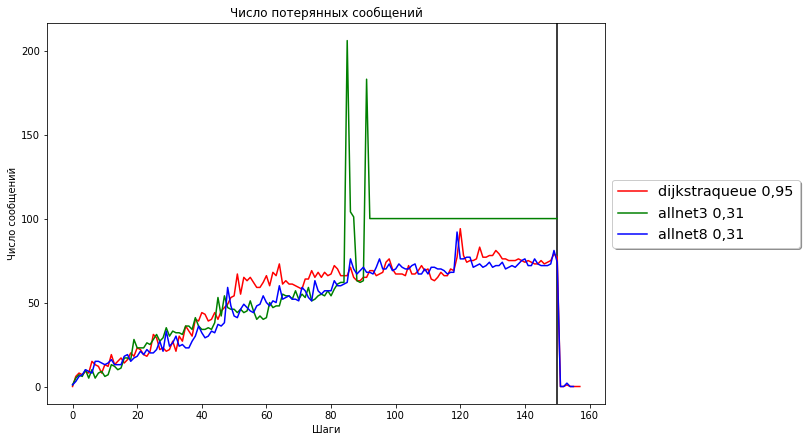

Доставлено 6789 Потеряно 54.7430% -dijkstraqueue 0,95
Доставлено 5300 Потеряно 64.6690% -allnet3 0,31
Доставлено 7311 Потеряно 51.2632% -allnet8 0,31


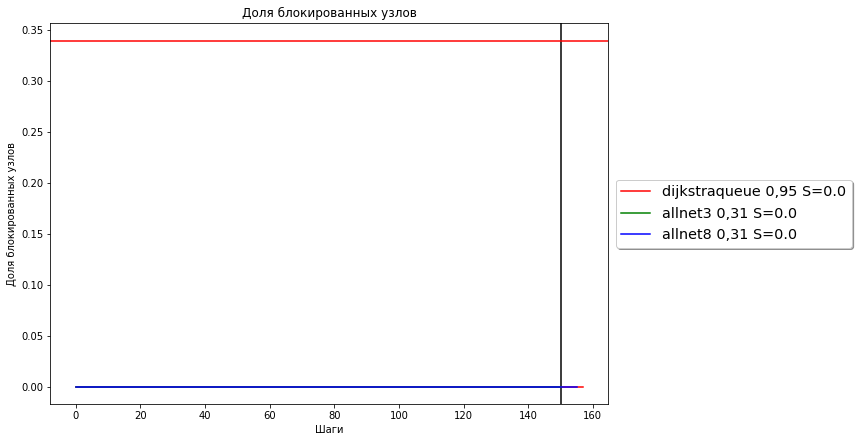

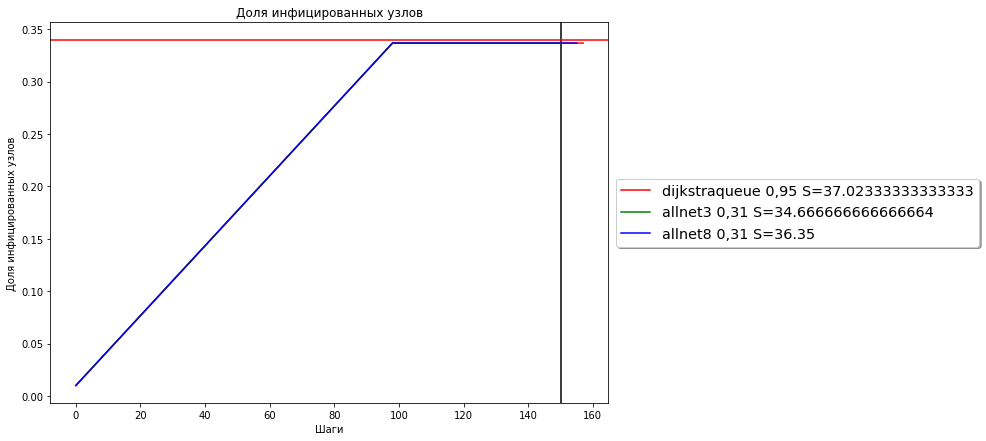

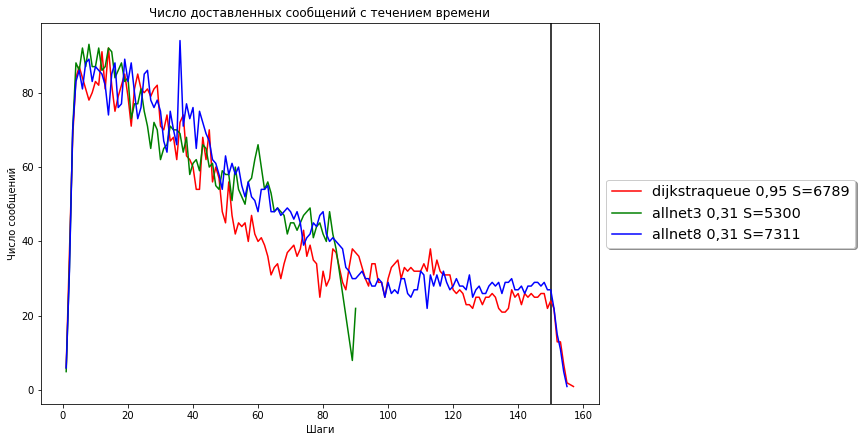

In [3]:
quantity = 100;
log_tags = [
{"tag":  "9b43b26a-5b76-48f9-aedf-55658ee4f6cf", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "21be34c6-5386-4bb1-89db-3fdc6dd40d6e", "label": "allnet3 0,31", "color": "green"},
{"tag":  "2a79811f-d292-4f4b-b05f-75d675f90c12", "label": "allnet8 0,31", "color": "blue"},
]
showStat()
showStatBlocked();  
showStatMessage();


<strong>Quantity 500 </strong>

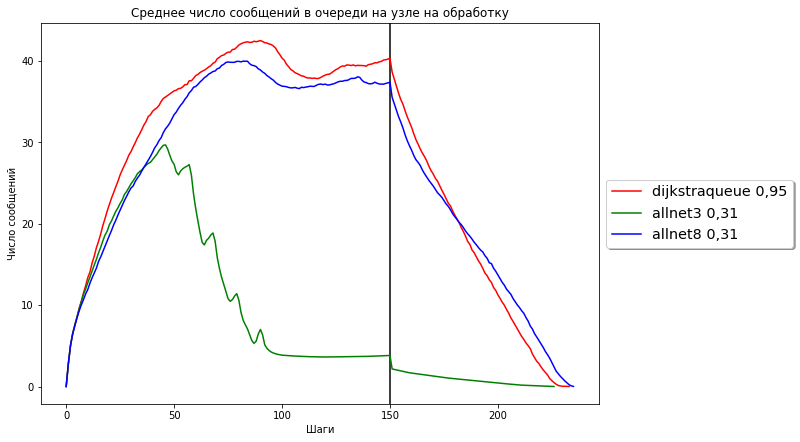

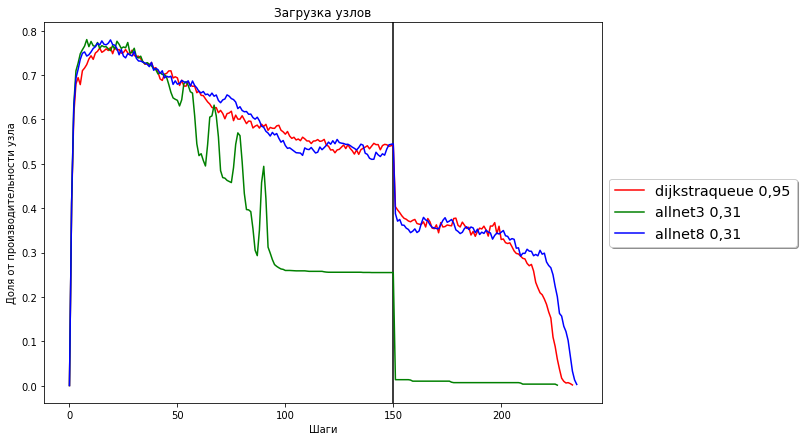

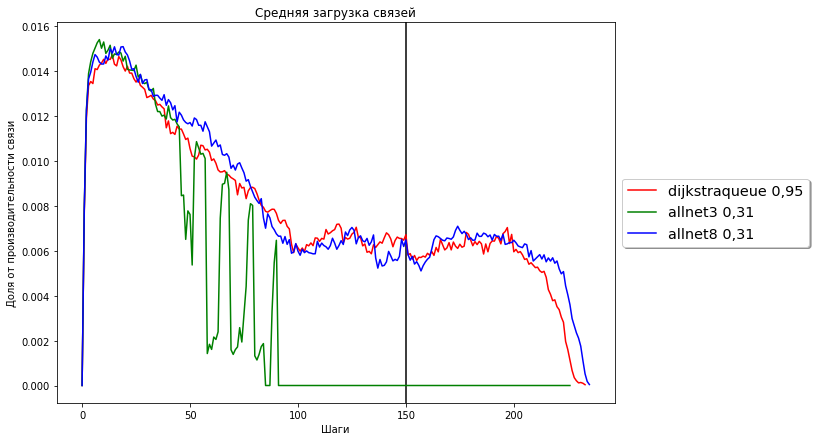

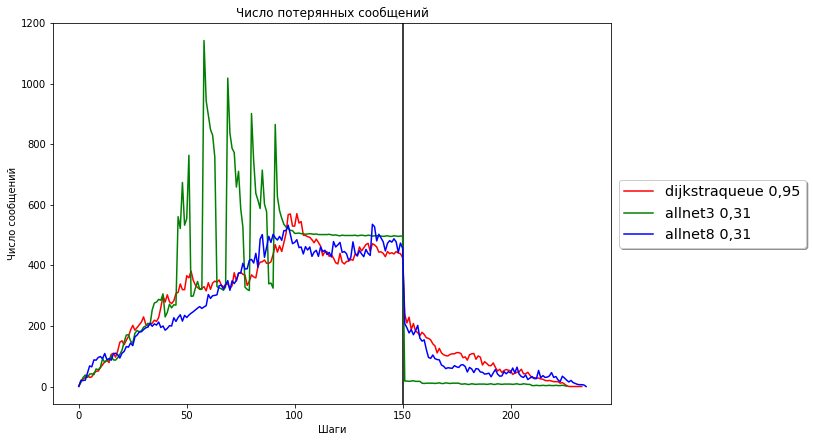

Доставлено 17700 Потеряно 76.4003% -dijkstraqueue 0,95
Доставлено 10869 Потеряно 85.5082% -allnet3 0,31
Доставлено 20388 Потеряно 72.8164% -allnet8 0,31


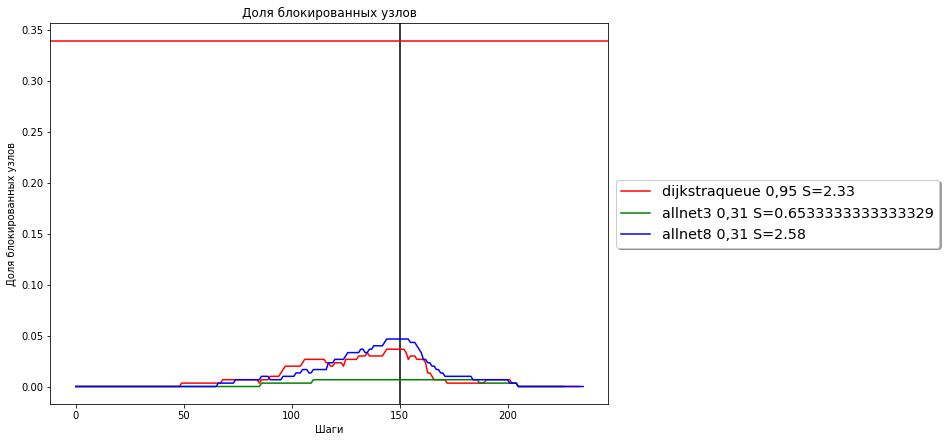

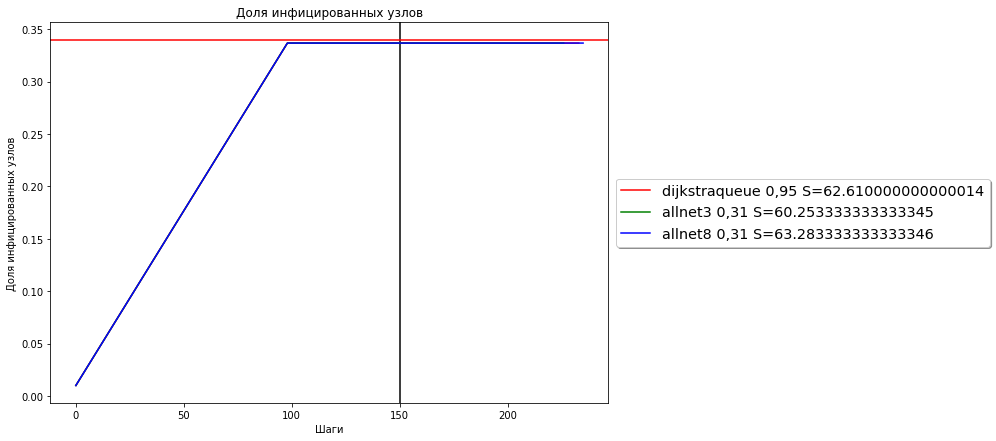

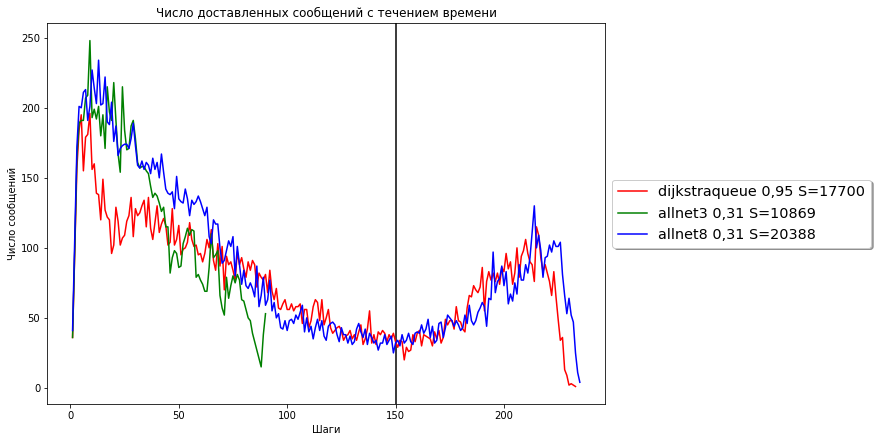

In [4]:
quantity = 500;
log_tags = [
{"tag":  "57fb47f3-5b86-4b6b-87a3-5c12b7b6541f", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "0fd67098-0b98-41b0-b099-5d1f6ad09b76", "label": "allnet3 0,31", "color": "green"},
{"tag":  "9eef9b81-bf90-45c0-845a-8fc840e94a56", "label": "allnet8 0,31", "color": "blue"},
]
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 1000 </strong>

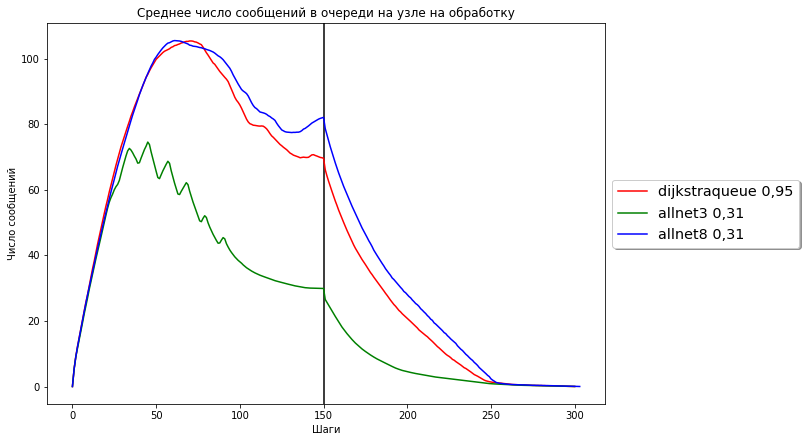

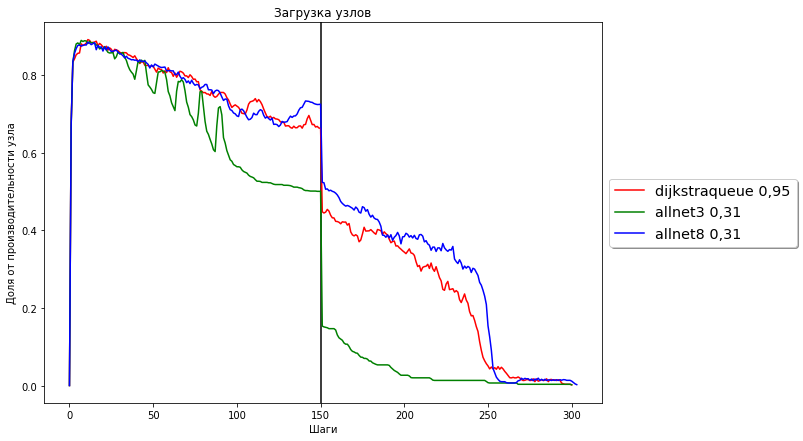

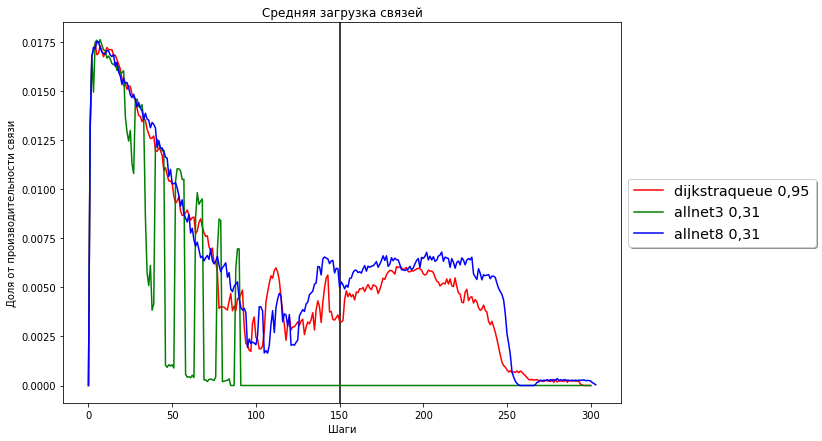

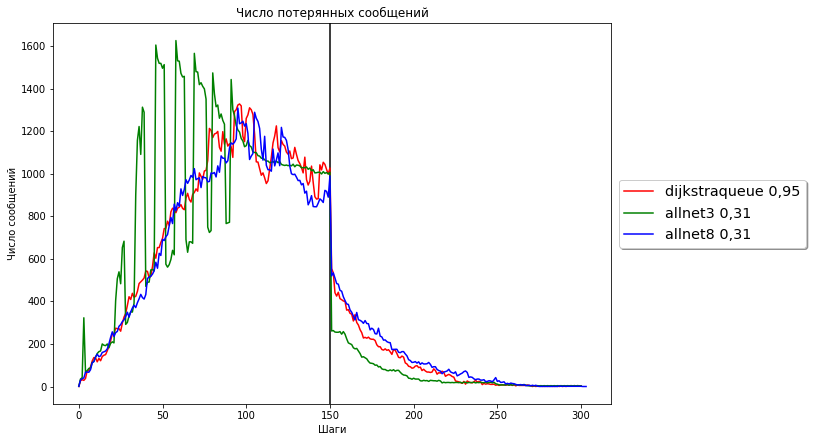

Доставлено 14554 Потеряно 90.2974% -dijkstraqueue 0,95
Доставлено 7245 Потеряно 95.1700% -allnet3 0,31
Доставлено 16346 Потеряно 89.1027% -allnet8 0,31


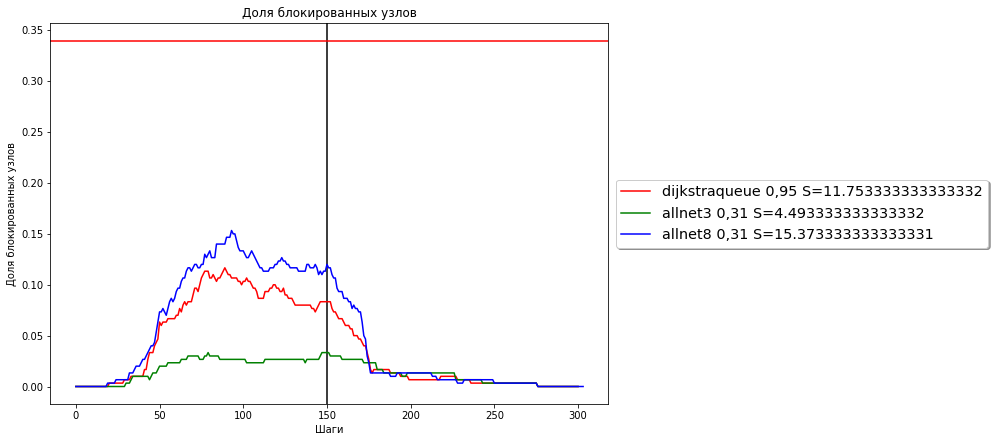

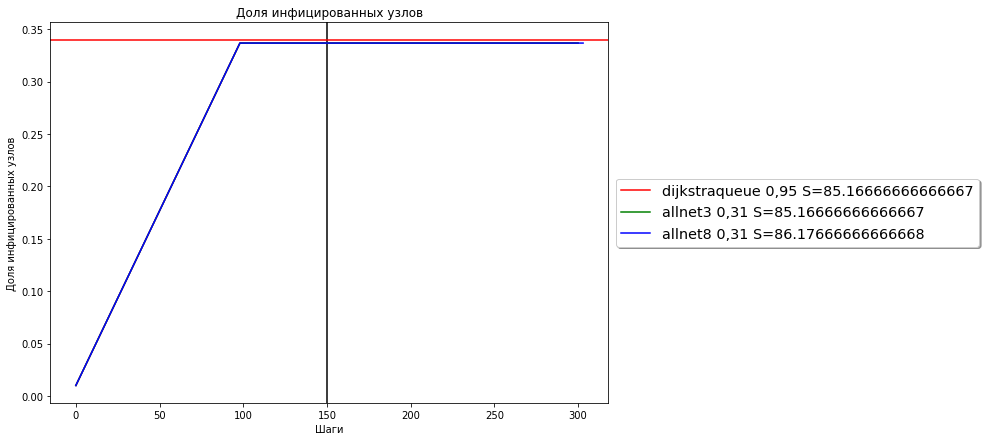

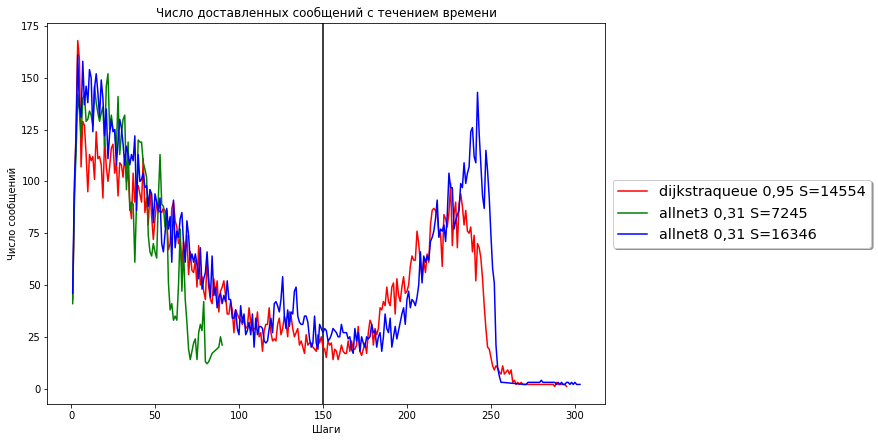

In [5]:
quantity = 1000;
log_tags = [
{"tag":  "e50731bb-2b51-4943-80aa-e0c0aff0af25", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "468ab1f3-afc2-4b88-afd5-61fb19a1795e", "label": "allnet3 0,31", "color": "green"},
{"tag":  "552b631a-3770-42ba-af49-51d64e26515b", "label": "allnet8 0,31", "color": "blue"},
]
showStat()
showStatBlocked();  
showStatMessage();


<strong>Quantity 1500 </strong>

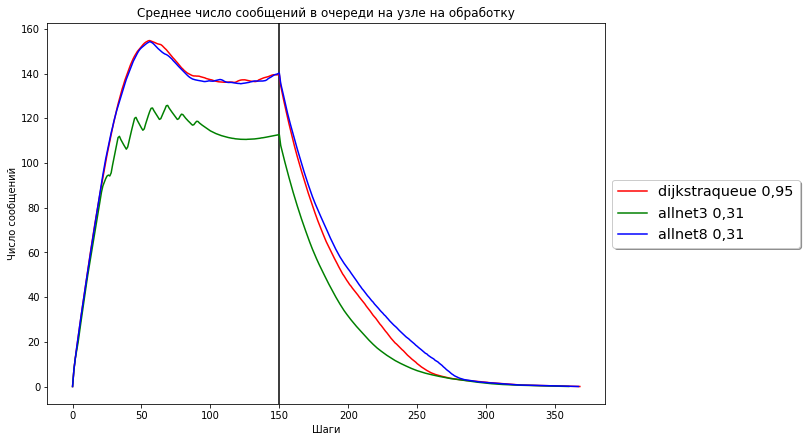

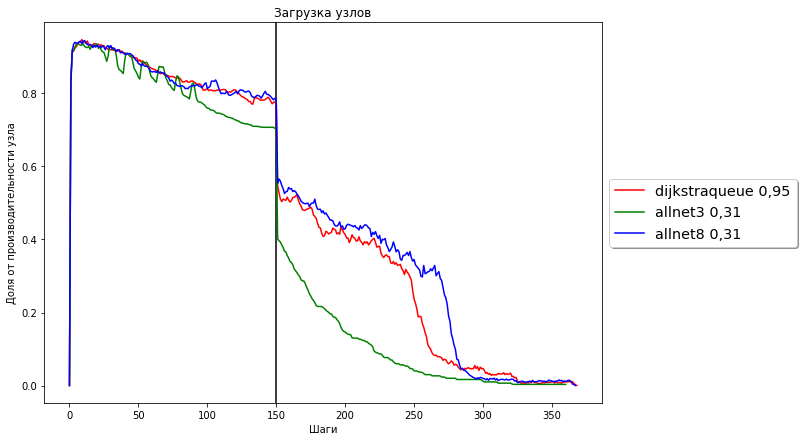

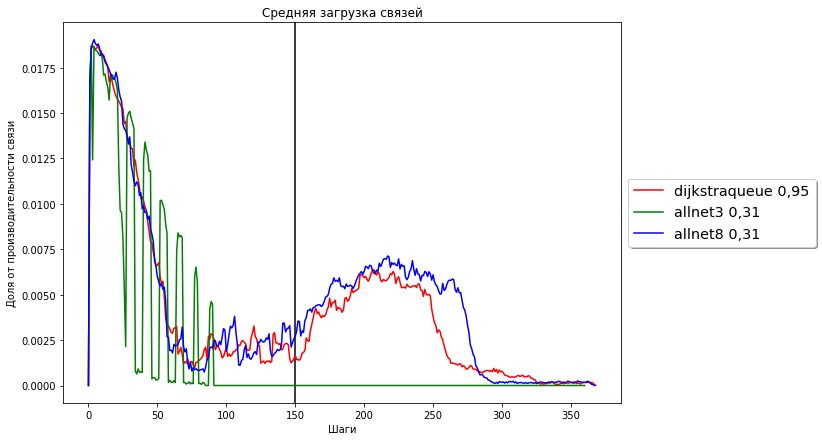

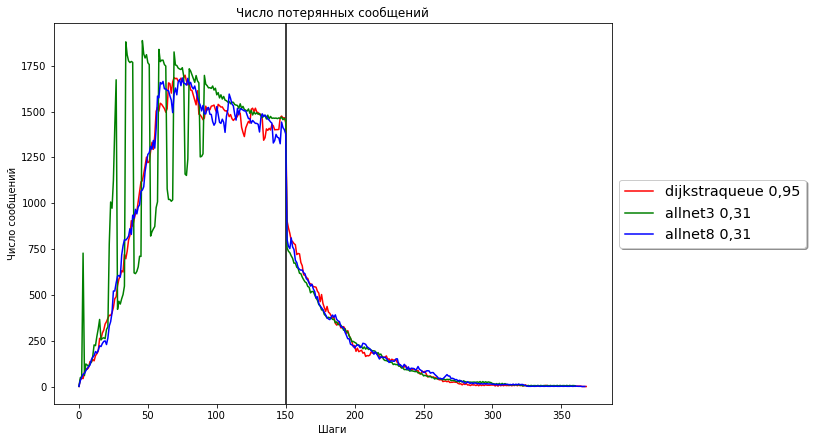

Доставлено 14243 Потеряно 93.6698% -dijkstraqueue 0,95
Доставлено 4740 Потеряно 97.8933% -allnet3 0,31
Доставлено 14164 Потеряно 93.7049% -allnet8 0,31


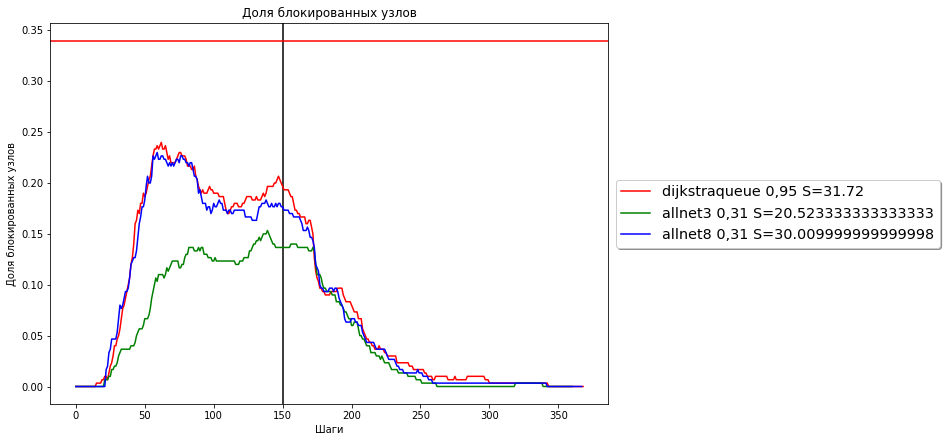

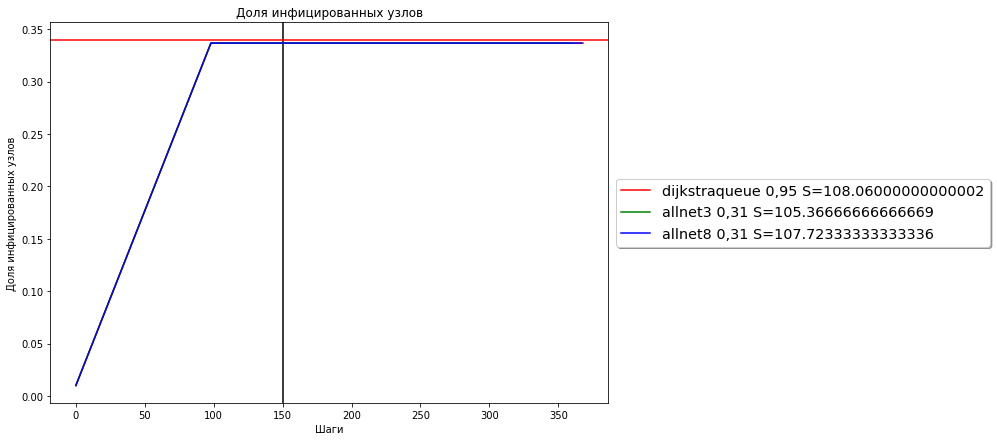

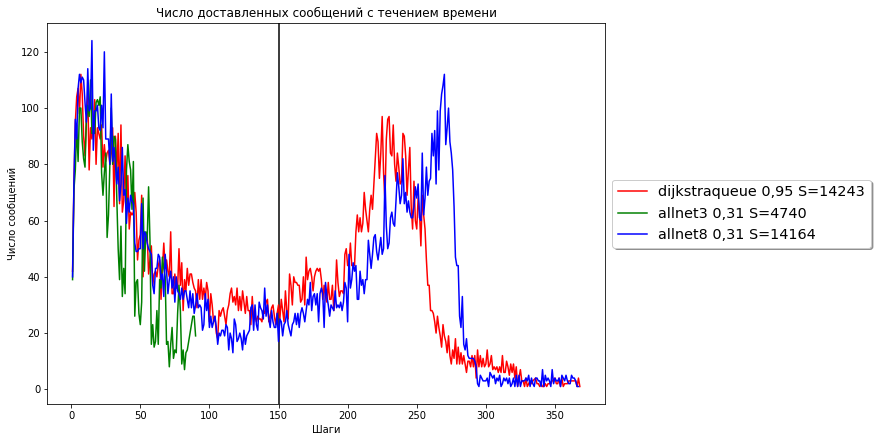

In [6]:
quantity = 1500;
log_tags = [
{"tag":  "4af479c8-857b-41bc-83aa-a5eae11e3658", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "6534a7d4-a3cf-4876-809f-e5d73b07802e", "label": "allnet3 0,31", "color": "green"},
{"tag":  "56953b82-9f3e-4bed-8816-14e1dfea8810", "label": "allnet8 0,31", "color": "blue"},
]
showStat()
showStatBlocked();  
showStatMessage();


Доставлено 17148 Потеряно 61.8942% -dijkstraqueue 0,95
Доставлено 13025 Потеряно 71.0562% -allnet3 0,31
Доставлено 20135 Потеряно 55.2565% -allnet8 0,31


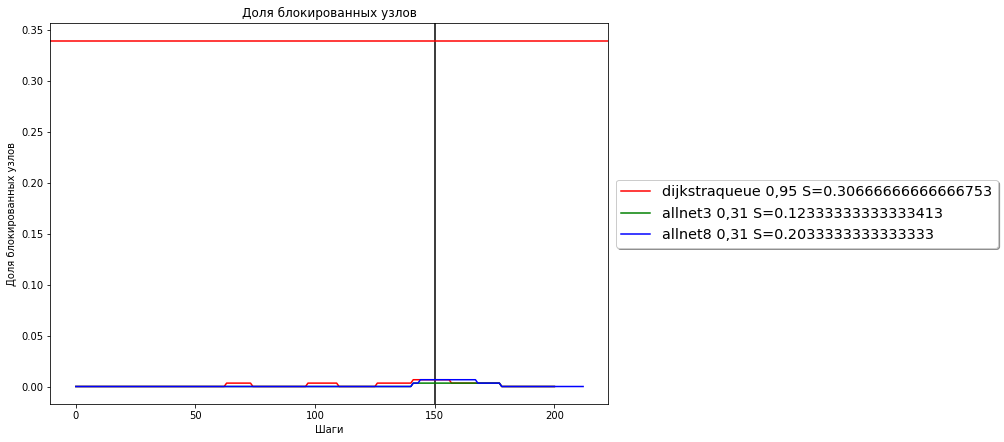

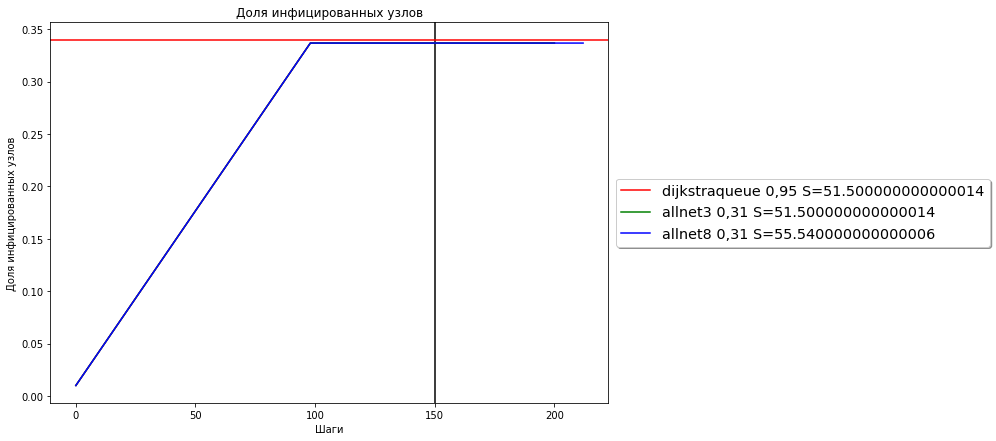

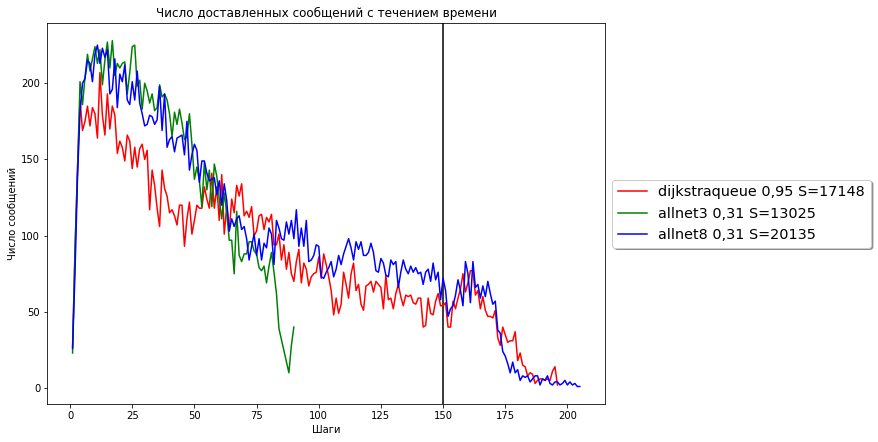

Доставлено 16351 Потеряно 84.4278% -dijkstraqueue 0,95
Доставлено 9089 Потеряно 91.3439% -allnet3 0,31
Доставлено 16674 Потеряно 84.1202% -allnet8 0,31


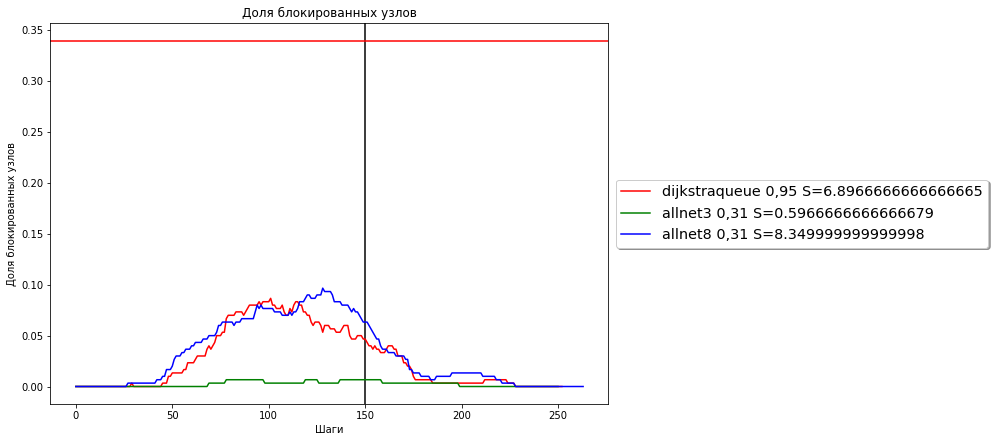

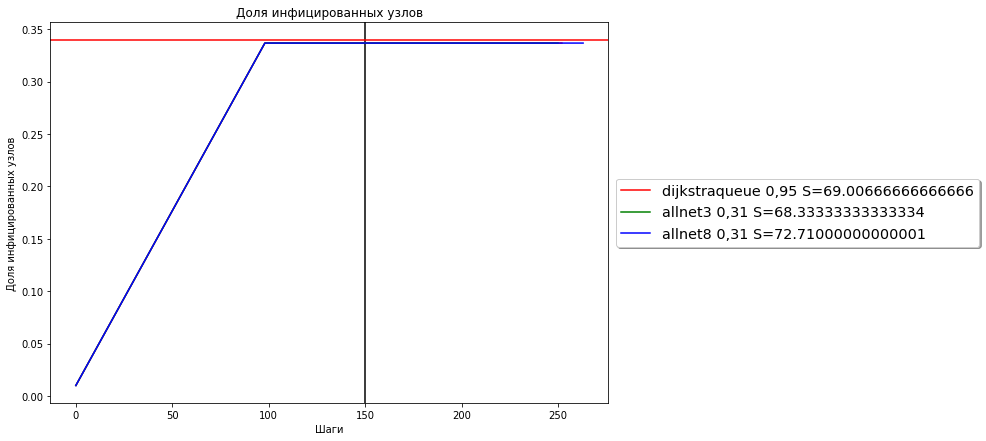

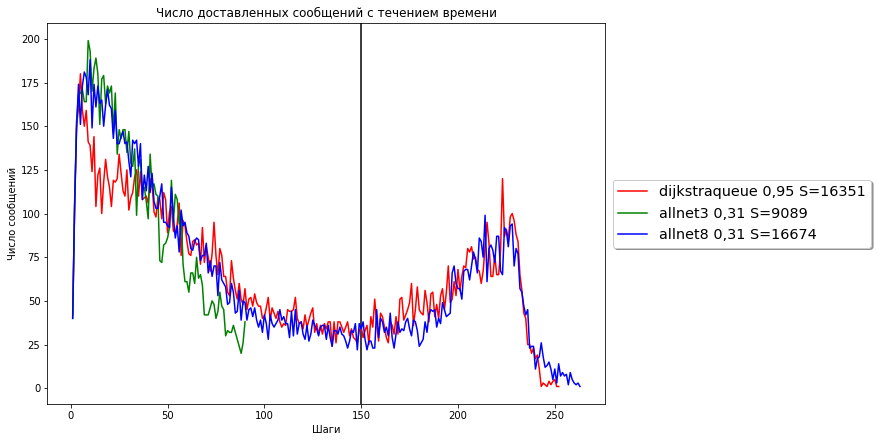

Доставлено 15658 Потеряно 88.4016% -dijkstraqueue 0,95
Доставлено 7455 Потеряно 94.4778% -allnet3 0,31
Доставлено 16226 Потеряно 87.9808% -allnet8 0,31


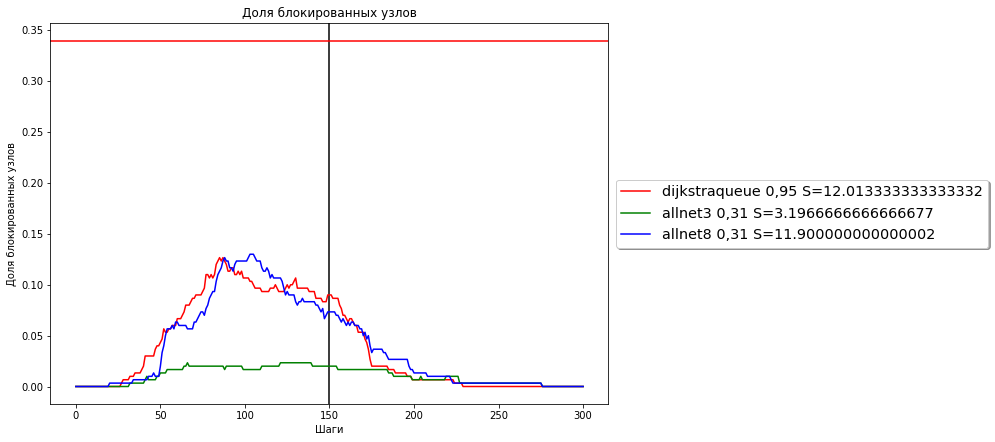

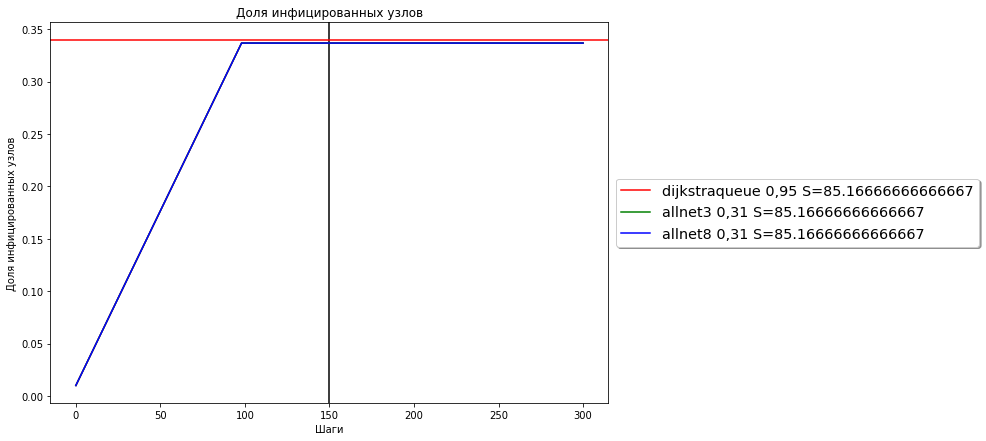

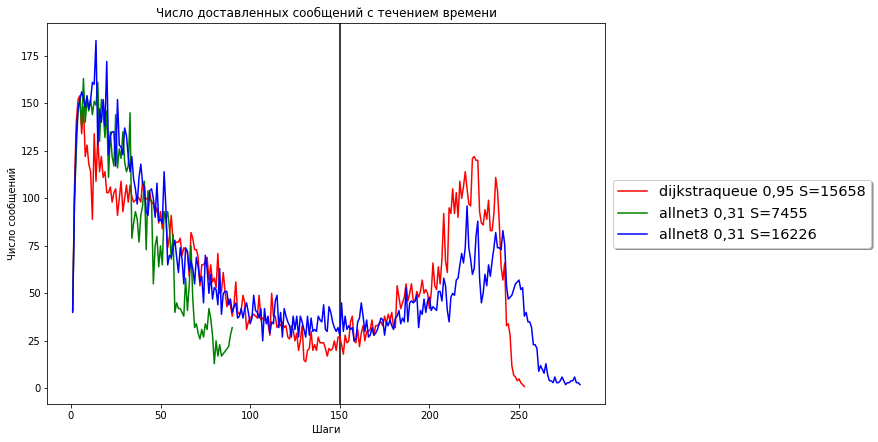

Доставлено 14740 Потеряно 92.4411% -dijkstraqueue 0,95
Доставлено 5428 Потеряно 97.2164% -allnet3 0,31
Доставлено 13540 Потеряно 93.0564% -allnet8 0,31


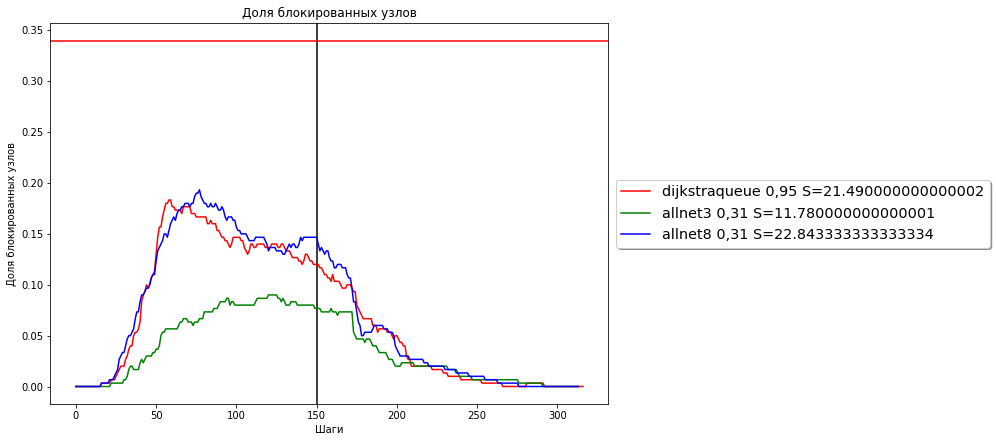

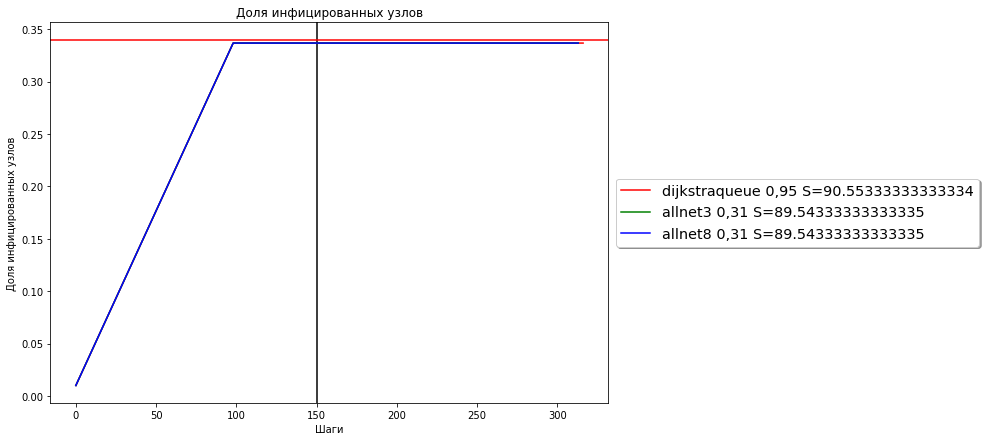

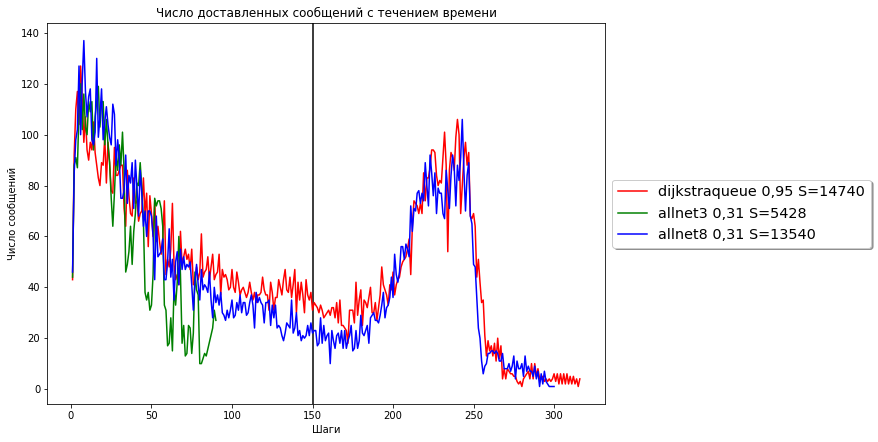

In [7]:
quantity = 300;
log_tags = [
{"tag":  "82fb8fc4-5d94-4db6-8982-5ce653a740cb", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "cb159aca-fbb5-4952-a6a4-61bd2526c7e6", "label": "allnet3 0,31", "color": "green"},
{"tag":  "08183a3d-2049-4c85-b73c-b71b899e1f56", "label": "allnet8 0,31", "color": "blue"},
]
showStatBlocked();
showStatMessage();

quantity = 700;
log_tags = [
{"tag":  "b77168c0-1f73-45c0-adc7-565492dcd6be", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "bae96376-a458-4023-9914-40319ee21698", "label": "allnet3 0,31", "color": "green"},
{"tag":  "5bf6c29e-341b-4c42-9ebb-f908f6464ae3", "label": "allnet8 0,31", "color": "blue"},
]
showStatBlocked();
showStatMessage();

quantity = 900;
log_tags = [
{"tag":  "976e930c-bb93-4e09-ae3a-f3836fbbaf3f", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "871fe784-8aa4-43d4-8912-f16c3dd5cb65", "label": "allnet3 0,31", "color": "green"},
{"tag":  "7d009a75-f542-482c-9462-354c0231af64", "label": "allnet8 0,31", "color": "blue"},
]
showStatBlocked();
showStatMessage();

quantity = 1300;
log_tags = [
{"tag":  "3fb58bb8-ec2e-475c-b792-43e64493bb68", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "0f5bd36c-001b-40b4-9913-ca5c57182201", "label": "allnet3 0,31", "color": "green"},
{"tag":  "9e95acf9-a4ed-4b4c-a52c-752fa43bda97", "label": "allnet8 0,31", "color": "blue"},
]
showStatBlocked();
showStatMessage();

      dijkstraqueue 0,95  allnet3 0,31  allnet8 0,31
100             2.283781      1.872209      2.245717
300            10.610609      3.753605      7.766961
500            24.831336      7.298823     23.583552
700            29.709565     10.734488     27.670327
900            29.214080     13.960223     28.397130
1000           27.955760     15.029320     30.172972
1300           28.712730     20.905170     29.071210
1500           32.628891     26.371932     33.373265


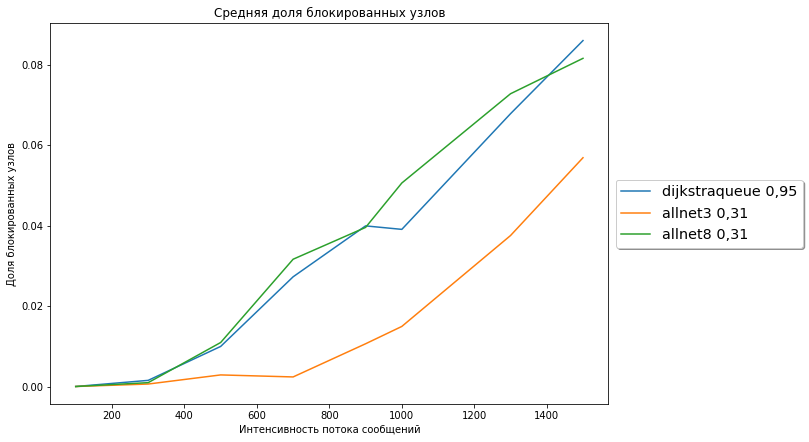

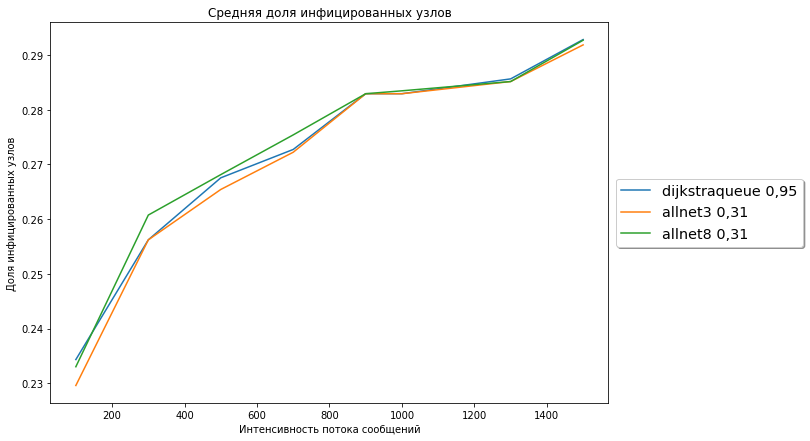

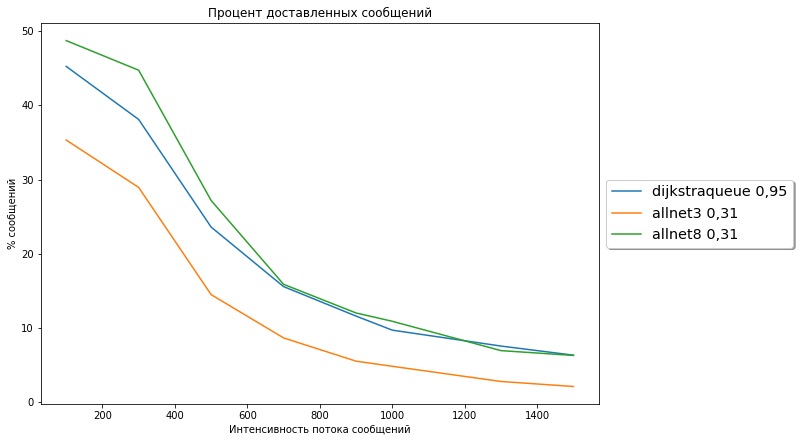

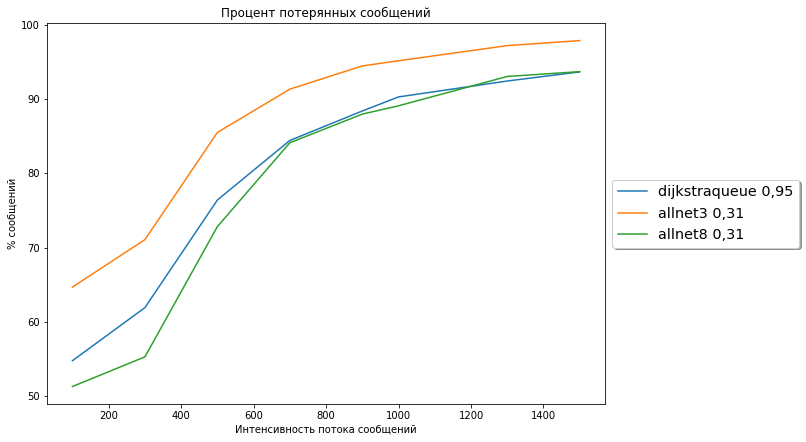

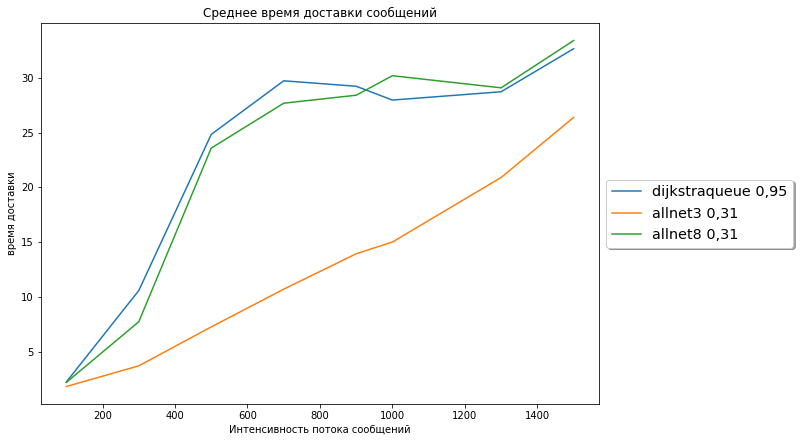

In [8]:
summBlocked.sort_index(inplace=True)
axs = summBlocked.plot()
axs.set_title("Средняя доля блокированных узлов")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("Доля блокированных узлов")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

summInfected.sort_index(inplace=True)
axs = summInfected.plot()
axs.set_title("Средняя доля инфицированных узлов")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("Доля инфицированных узлов")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageResived.sort_index(inplace=True)
axs = MessageResived.plot()
axs.set_title("Процент доставленных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageFall.sort_index(inplace=True)
axs = MessageFall.plot()
axs.set_title("Процент потерянных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageTimeSpent.sort_index(inplace=True)
axs = MessageTimeSpent.plot()
axs.set_title("Среднее время доставки сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("время доставки")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()
print (MessageTimeSpent)




In [9]:
print(summBlocked.mean().to_string())
print("")
print(MessageFall.mean().to_string())
print("")
print(MessageTimeSpent.mean().to_string())

print("")
print(summInfected.mean().to_string())

dijkstraqueue 0,95    0.033932
allnet3 0,31          0.015723
allnet8 0,31          0.035990

dijkstraqueue 0,95    80.284389
allnet3 0,31          87.166866
allnet8 0,31          78.412656

dijkstraqueue 0,95    23.243344
allnet3 0,31          12.490721
allnet8 0,31          22.785142

dijkstraqueue 0,95    0.271907
allnet3 0,31          0.270802
allnet8 0,31          0.272706
